In this example we create a FreeGS equilibrium **inspired** by experimental results.

> **Note: this example will only run within Tokamak Energy's network**

Then, we use the FreeGS magnetic sensors as measurements to run GSFit.
This type of workflow is useful for sensitivity and "what if" modelling.
For example:
What are the optimal sensor weights and how sensitive is the result to the sensor weights?
What if we add an extra PF coil?
What if we add additional magnetic sensors?

In [1]:
import copy

import freegs
import matplotlib.pyplot as plt
import numpy as np
from freegs.machine import Machine
from freegs.machine import MultiCoil
from freegs.machine import Wall
from gsfit import Gsfit
from scipy import interpolate
from shapely.geometry import LineString
from shapely.geometry import Point
from st40_database import GetData

# Set the Matplotlib backend (inline=png; widget=interactive)
%matplotlib inline
# %matplotlib widget

# Set the random seed for reproducibility
rng = np.random.default_rng(12345)

In [2]:
# Define what we want to reconstruct
pulseNo = 12050
times_to_reconstruct = 130.0e-3

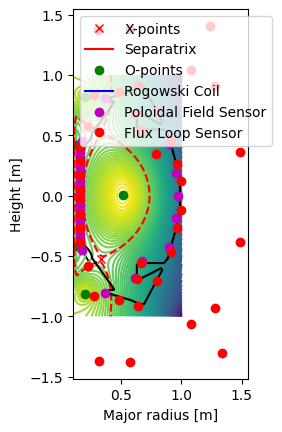

In [3]:
# Set-up ST40 FreeGS PF coils
elmag_run_name = "RUN16"
elmag = GetData(11012050, f"ELMAG#{elmag_run_name}")

coils_r = elmag.get("COILS.R")
coils_z = elmag.get("COILS.Z")
coils_d_r = elmag.get("COILS.DR")
coils_d_z = elmag.get("COILS.DZ")
coil_names = elmag.get("COILS.COIL_NAMES")
fils2coils = elmag.get("COILS.FILS2COILS") == 1.0

psu2coil = GetData(12050, "PSU2COIL#RUN02")
time_experimental = psu2coil.get("TIME")

freegs_coils = []

for i_coil, coil_name in enumerate(coil_names):
    i_filaments = fils2coils[:, i_coil]
    coil_r = coils_r[i_filaments]
    coil_z = coils_z[i_filaments]
    coil_d_r = coils_d_r[i_filaments]
    coil_d_z = coils_d_z[i_filaments]
    n_turns = len(coil_r)
    # Skip the MCT, MCB, PSHT, and PSHB coils
    if coil_name == "MCT" or coil_name == "MCB" or coil_name == "PSHT" or coil_name == "PSHB":
        continue

    if coil_name == "SOL":
        current_experimental = psu2coil.get("PF.SOL.I")
        control = False
    elif coil_name == "DIVT" or coil_name == "DIVB":
        current_experimental = psu2coil.get("PF.DIV.I") * 1.00
        control = False
    elif coil_name == "BVUT":
        current_experimental = psu2coil.get("PF.BVUT.I") * 0.78
        control = True
    elif coil_name == "BVUB":
        current_experimental = psu2coil.get("PF.BVUT.I") * 0.78
        control = True
    elif coil_name == "BVL":
        current_experimental = psu2coil.get("PF.BVL.I") * 0.80  # Less BVL current to ensure the plasma is x-point diverted
        control = False
    else:
        current_experimental = psu2coil.get(f"PF.{coil_name[0:-1]}.I")
        control = False

    current = np.interp(times_to_reconstruct, time_experimental, current_experimental)
    coil = MultiCoil(coil_r, coil_z, current=current, control=control)
    freegs_coils.append((coil_name, coil))

# Set-up ST40 FreeGS magnetic sensors
# Initialize the sensors list
freegs_sensors = []

mag = GetData(pulseNo, "MAG#BEST")

# Add bp_probes
bp_names = mag.get("BPPROBE.ALL_000.NAMES")
for bp_name in bp_names:
    bp_name_short = bp_name.split("_")[1]
    angle = mag.get(f"BPPROBE.P{bp_name_short}.ANGLE")
    r = mag.get(f"BPPROBE.P{bp_name_short}.R")
    z = mag.get(f"BPPROBE.P{bp_name_short}.Z")

    # Add bp_sensors to the `tokamak` object
    freegs_sensor = freegs.machine.PoloidalFieldSensor(
        R=r,
        Z=z,
        theta=angle,
        name=f"P{bp_name_short}",
    )
    freegs_sensors.append(freegs_sensor)

# Add flux loop sensors
fl_names = mag.get("FLOOP.ALL.NAMES")
for fl_name in fl_names:
    fl_name_short = fl_name.split("_")[1]
    r = mag.get(f"FLOOP.L{fl_name_short}.R")
    z = mag.get(f"FLOOP.L{fl_name_short}.Z")

    # Add bp_sensors to the `tokamak` object
    freegs_sensor = freegs.machine.FluxLoopSensor(
        R=r,
        Z=z,
        name=f"L{fl_name_short}",
    )
    freegs_sensors.append(freegs_sensor)


# Plasma current
gsfit_database = GetData(12050, "GSFIT#TEST12")
time_gsfit_database = gsfit_database.get("TIME")
ip_experimental = gsfit_database.get("GLOBAL.IP")
ip = np.interp(times_to_reconstruct, time_gsfit_database, ip_experimental)

# Set-up ST40 FreeGS Wall
r_limit_pts = elmag.get("LIMITER.LIMIT_PTS.R")
z_limit_pts = elmag.get("LIMITER.LIMIT_PTS.Z")
freegs_wall = Wall(r_limit_pts, z_limit_pts)

# Set-up ST40 FreeGS Machine
freegs_tokamak = Machine(
    coils=freegs_coils,
    wall=freegs_wall,
    sensors=freegs_sensors,
)

# Set-up ST40 FreeGS Equilibrium
freegs_eq = freegs.Equilibrium(
    tokamak=freegs_tokamak,
    Rmin=0.1,
    Rmax=1.0,
    Zmin=-1.0,
    Zmax=1.0,
    nx=129,
    ny=129,
    current=ip,
)

# Set-up ST40 FreeGS plasma profiles
profiles = freegs.jtor.ConstrainPaxisIp(
    eq=freegs_eq,
    paxis=40e3,  # Plasma pressure on axis [Pascals]
    Ip=ip,  # Plasma current [Amps]
    fvac=1.8 * 0.4,  # vacuum f = R*Bt
    alpha_m=1.0,
    alpha_n=1.0,
)

# To avoid the VDE, we need to add constraints
xpoints = [
    (0.328, -0.532),  # (R,Z) locations of X-points
    (0.328, 0.535),  # (R,Z) locations of X-points
]
constrain = freegs.control.constrain(xpoints)

# Solve the Grad-Shafranov equation
freegs.solve(
    freegs_eq,  # The equilibrium object
    profiles,
    constrain=constrain,  # Forward solver, no constraints
    show=False,  # Don't plot results while solving
)

# Take measurements
freegs_eq.tokamak.takeMeasurements(eq=freegs_eq)

# Plot the equilibrium solution
freegs_eq.plot();

In [4]:
gsfit_controller = Gsfit(
    pulseNo=None,
    run_name="test_01",
    run_description="using FreeGS to generate measurements",
    settings_path="st40_all_magnetic_sensors_working",
    write_to_mds=False,
)
gsfit_controller.settings["GSFIT_code_settings.json"]["database_reader"]["method"] = "freegs"
gsfit_controller.settings["GSFIT_code_settings.json"]["timeslices"]["method"] = "user_defined"
gsfit_controller.settings["GSFIT_code_settings.json"]["timeslices"]["user_defined"] = [0.5]

gsfit_controller.run(time=np.array([0.0, 1.0]), freegs_eqs=[freegs_eq, freegs_eq])

2025-07-15 21:50:20  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "GSFIT_code_settings.json"
2025-07-15 21:50:20  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "passive_dof_regularisation.json"
2025-07-15 21:50:20  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_bp_probe.json"
2025-07-15 21:50:20  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_dialoop.json"
2025-07-15 21:50:20  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_flux_loops.json"
2025-07-15 21:50:20  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_isoflux.json"
2025-07-15 21:50:20  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_pressure.json"
2025-07-15 21:50:20  |  GSFI

2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:267                           |  INFO  |  `coils` initialised
2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:269                           |  INFO  |  `bp_probes` initialised
2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:271                           |  INFO  |  `flux_loops` initialised
2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:273                           |  INFO  |  `rogowski_coils` initialised
2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:275                           |  INFO  |  `passives` initialised
2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:277                           |  INFO  |  `plasma` initialised
2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:280                           |  INFO  |  `isoflux` initialised
2025-07-15 21:50:21  |  GSFIT  |  gsfit.py:282                           |  INFO  |  `isoflux_boundary` initialised
2025-07-15 21:50:22  |  GSFIT  |  gsfit.py:230                           |  INFO  |  Finished Greens with coils
2025-07-15 21

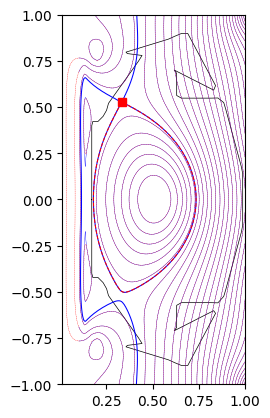

In [5]:
# Compare the FreeGS equilibrium to the GSFit equilibrium
freegs_r = freegs_eq.R
freegs_z = freegs_eq.Z
freegs_r_1d = freegs_eq.R_1D
freegs_z_1d = freegs_eq.Z_1D
freegs_psi = freegs_eq.psiRZ(freegs_r, freegs_z).T * (2.0 * np.pi)  # Convert from Wb/(2*pi) to Wb
freegs_psi_b = freegs_eq.psi_bndry * (2.0 * np.pi)

# Note: we will plot with the same `psi_range` for FreeGS and GSFit
psi_range = np.linspace(np.min(freegs_psi), np.max(freegs_psi), 30)

i_time = 0  # only one time-slice
gsfit_psi = gsfit_controller["TWO_D"]["PSI"][i_time, :, :]
gsfir_r = gsfit_controller.plasma.get_array1(["grid", "r"])
gsfit_z = gsfit_controller.plasma.get_array1(["grid", "z"])
gsfit_no_noise_rbnd = gsfit_controller.plasma.get_array2(["p_boundary", "rbnd"])[i_time, :]
gsfit_no_noise_zbnd = gsfit_controller.plasma.get_array2(["p_boundary", "zbnd"])[i_time, :]
bounding_r = gsfit_controller.plasma.get_array1(["p_boundary", "bounding_r"])
bounding_z = gsfit_controller.plasma.get_array1(["p_boundary", "bounding_z"])

plt.figure()
plt.plot(r_limit_pts, z_limit_pts, color="black", linewidth=0.5)
plt.contour(freegs_r_1d, freegs_z_1d, freegs_psi, levels=psi_range, colors="blue", linewidths=0.25, linestyles="solid")
plt.contour(freegs_r_1d, freegs_z_1d, freegs_psi, [freegs_psi_b], colors="blue", linewidths=0.75, linestyles="solid")  # , label="FreeGS"

plt.contour(gsfir_r, gsfit_z, gsfit_psi, levels=psi_range, colors="red", linewidths=0.25, linestyles="dashed")
plt.plot(gsfit_no_noise_rbnd, gsfit_no_noise_zbnd, color="red", linewidth=0.75, linestyle="dashed", label="GSFit")
plt.plot(bounding_r[i_time], bounding_z[i_time], "s", color="red")

plt.gca().set_aspect("equal")

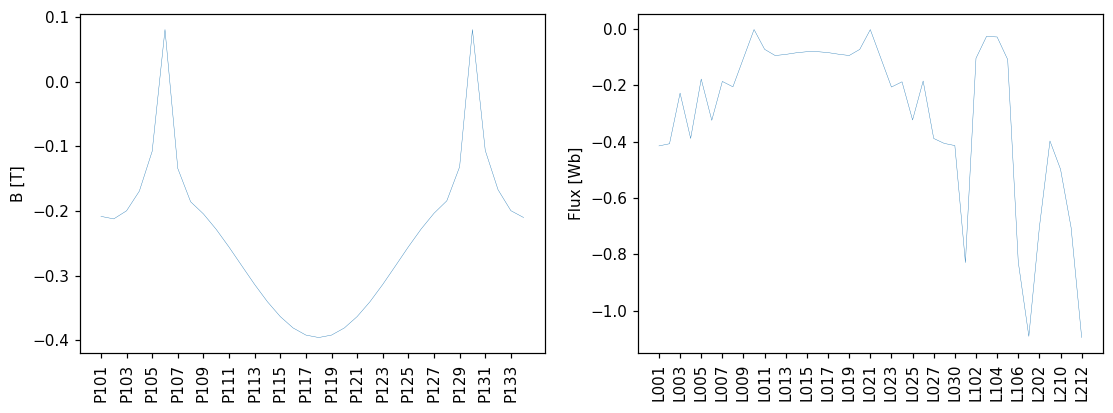

In [6]:
freegs_d_psi_d_z, freegs_d_psi_d_r = np.gradient(freegs_psi, freegs_z_1d, freegs_r_1d)
freegs_br = -(1.0 / (2.0 * np.pi * freegs_r_1d)) * freegs_d_psi_d_z
freegs_bz = (1.0 / (2.0 * np.pi * freegs_r_1d)) * freegs_d_psi_d_r

f_br = interpolate.RectBivariateSpline(freegs_z_1d, freegs_r_1d, freegs_br)
f_bz = interpolate.RectBivariateSpline(freegs_z_1d, freegs_r_1d, freegs_bz)

b_check = []
for sensor_name in gsfit_controller.bp_probes.keys():
    r = gsfit_controller.bp_probes.get_f64([sensor_name, "geometry", "r"])
    z = gsfit_controller.bp_probes.get_f64([sensor_name, "geometry", "z"])
    angle_pol = gsfit_controller.bp_probes.get_f64([sensor_name, "geometry", "angle_pol"])
    value = f_br(z, r)[0, 0] * np.cos(angle_pol) + f_bz(z, r)[0, 0] * np.sin(angle_pol)
    b_check.append(value)


def plot_magnetic_probes(gsfit_controller):
    _fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=110)

    time = gsfit_controller.plasma.get_array1(["time"])
    n_time = len(time)

    # Bp probes
    bp_probes = gsfit_controller.bp_probes
    measured = bp_probes.get_array2(["*", "b", "measured"])
    bp_probe_names = bp_probes.keys()
    for i_time in range(0, n_time):
        ax[0].plot(bp_probe_names, measured[i_time, :], linewidth=0.25)
    ax[0].tick_params(axis="x", rotation=90.0)
    ax[0].set_xticks(range(0, len(bp_probe_names), 2))
    ax[0].set_ylabel("B [T]")

    # Flux loops
    flux_loops = gsfit_controller.flux_loops
    measured = flux_loops.get_array2(["*", "psi", "measured"])
    flux_loops_names = flux_loops.keys()
    for i_time in range(0, n_time):
        ax[1].plot(flux_loops_names, measured[i_time, :], linewidth=0.25)
    ax[1].tick_params(axis="x", rotation=90.0)
    ax[1].set_xticks(range(0, len(flux_loops_names), 2))
    ax[1].set_ylabel("Flux [Wb]")


plot_magnetic_probes(gsfit_controller)

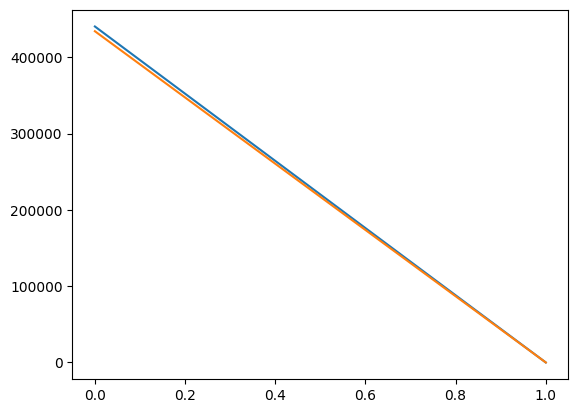

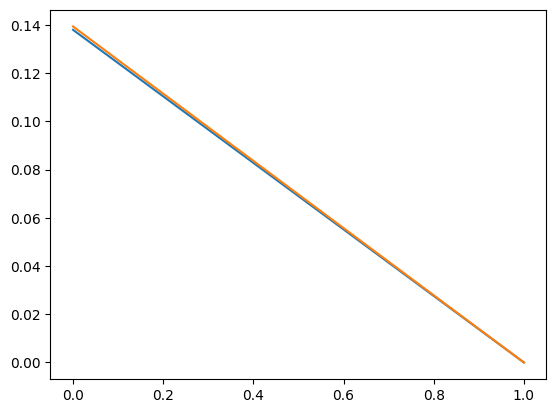

In [7]:
psi_n = gsfit_controller.plasma.get_array1(["profiles", "psi_n"])
p_prime = gsfit_controller.plasma.get_array2(["profiles", "p_prime"])[0, :]
ff_prime = gsfit_controller.plasma.get_array2(["profiles", "ff_prime"])[0, :]

freegs_p_prime = freegs_eq.pprime(psi_n)
freegs_ff_prime = freegs_eq.ffprime(psi_n)

plt.figure()
plt.plot(psi_n, freegs_p_prime / (2.0 * np.pi), label="FreeGS p'")
plt.plot(psi_n, p_prime, label="GSFit p'")

plt.figure()
plt.plot(psi_n, freegs_ff_prime / (2.0 * np.pi), label="FreeGS ff'")
plt.plot(psi_n, ff_prime, label="GSFit ff'")

Instead of adding random noise to the measurement.
I should add the random error to the probe positions.

In [8]:
# Add random noise to the measurements
n_random_scans = 350  # more than 350 becomes quite slow

# Add random noise to the positions of the magnetic sensors
freegs_eqs_with_random_noise = []
freegs_eqs_with_random_noise.append(freegs_eq)  # The original equilibrium comes first
for i_random_scan in range(1, n_random_scans):
    freegs_eq_with_random_noise = copy.deepcopy(freegs_eq)
    # Use the rng Generator for deterministic random noise
    for i_sensor, sensor in enumerate(freegs_eq.tokamak.sensors):
        # measurement = sensor.measurement
        r_sensor = sensor.R
        z_sensor = sensor.Z

        # Add random normal noise to the sensor positions
        freegs_eq_with_random_noise.tokamak.sensors[i_sensor].R = rng.normal(r_sensor, 2e-3)
        freegs_eq_with_random_noise.tokamak.sensors[i_sensor].Z = rng.normal(z_sensor, 2e-3)

        try:
            angle_no_noise = sensor.theta
            freegs_eq_with_random_noise.tokamak.sensors[i_sensor].theta = rng.normal(angle_no_noise, np.deg2rad(2.5))
        except:
            pass

    # Take measurements
    freegs_eq_with_random_noise.tokamak.takeMeasurements(eq=freegs_eq_with_random_noise)

    # Append the modified equilibrium to the list to be reconstructed
    freegs_eqs_with_random_noise.append(freegs_eq_with_random_noise)

In [9]:
# GSFit reconstruction with random noise
time = np.linspace(0.0, 1.0, n_random_scans)
gsfit_controller.settings["GSFIT_code_settings.json"]["timeslices"]["method"] = "user_defined"
gsfit_controller.settings["GSFIT_code_settings.json"]["timeslices"]["user_defined"] = time.tolist()

# Solve with random noise
gsfit_controller.run(time=time, freegs_eqs=freegs_eqs_with_random_noise)

2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:90                            |  INFO  |  Running Gsfit, for pulseNo=None
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:267                           |  INFO  |  `coils` initialised
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:269                           |  INFO  |  `bp_probes` initialised
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:271                           |  INFO  |  `flux_loops` initialised
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:273                           |  INFO  |  `rogowski_coils` initialised
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:275                           |  INFO  |  `passives` initialised
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:277                           |  INFO  |  `plasma` initialised
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:280                           |  INFO  |  `isoflux` initialised
2025-07-15 21:53:23  |  GSFIT  |  gsfit.py:282                           |  INFO  |  `isoflux_boundary` initialised
2025-07-

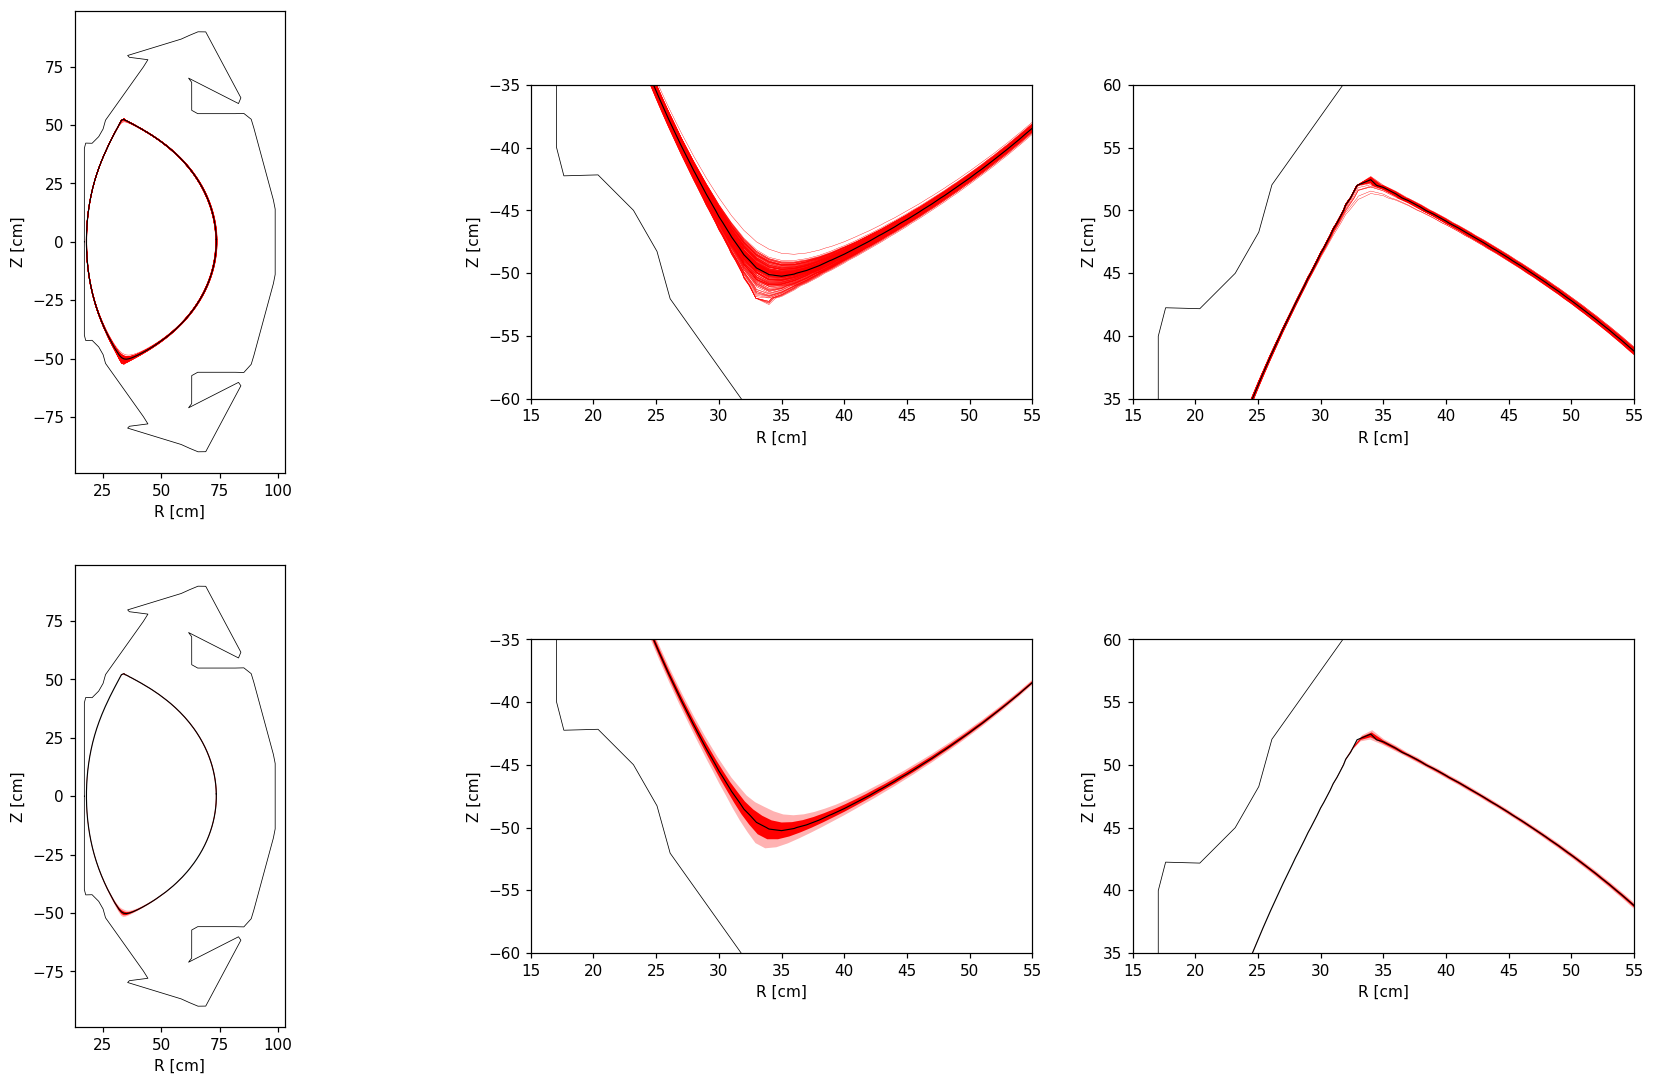

In [11]:
def plot_equilibrium(gsfit_controller, plot_color="red", ax=None):
    # Create a figure and axes if not provided
    if ax is None:
        _fig, ax = plt.subplots(2, 3, figsize=(20, 12), dpi=110)

    plasma = gsfit_controller.plasma

    for i_x in [0, 1, 2]:
        ax[0, i_x].set_aspect("equal")
        for i_time in range(1, int(n_random_scans / 2.0)):  # 0th time-slice is without noise
            gsfit_rbnd = plasma.get_array2(["p_boundary", "rbnd"])[i_time, :]
            gsfit_zbnd = plasma.get_array2(["p_boundary", "zbnd"])[i_time, :]
            ax[0, i_x].plot(gsfit_rbnd * 100.0, gsfit_zbnd * 100.0, color=plot_color, linewidth=0.25)
        ax[0, i_x].plot(gsfit_no_noise_rbnd * 100.0, gsfit_no_noise_zbnd * 100.0, color="black", linewidth=0.75)
        ax[0, i_x].plot(r_limit_pts * 100.0, z_limit_pts * 100.0, color="black", linewidth=0.5)
        ax[0, i_x].set_xlabel("R [cm]")
        ax[0, i_x].set_ylabel("Z [cm]")

    ax[0, 1].set_xlim(15.0, 55.0)
    ax[0, 1].set_ylim(-60.0, -35.0)

    ax[0, 2].set_xlim(15.0, 55.0)
    ax[0, 2].set_ylim(35.0, 60.0)

    r_geo_no_noise = plasma.get_array1(["global", "r_geo"])[0]
    z_geo_no_noise = plasma.get_array1(["global", "z_geo"])[0]

    # Go around the boundary and find the intersections
    n_theta = 400  # perhaps higher??
    thetas = np.linspace(0.0, 2.0 * np.pi, n_theta)

    # Loop over the last closed flux surface
    one_sigma_inner_r = np.full(n_theta, np.nan)
    one_sigma_inner_z = np.full(n_theta, np.nan)
    one_sigma_outer_r = np.full(n_theta, np.nan)
    one_sigma_outer_z = np.full(n_theta, np.nan)
    ci95_inner_r = np.full(n_theta, np.nan)
    ci95_inner_z = np.full(n_theta, np.nan)
    ci95_outer_r = np.full(n_theta, np.nan)
    ci95_outer_z = np.full(n_theta, np.nan)
    for i_theta in range(0, n_theta):
        theta = thetas[i_theta]

        normal_distribution_r = np.full(n_random_scans - 1, np.nan)  # first time-slice is without noise
        normal_distribution_z = np.full(n_random_scans - 1, np.nan)
        #
        for i_time in range(1, n_random_scans):  # 0th time-slice is without noise
            gsfit_nbnd = plasma.get_vec_usize(["p_boundary", "nbnd"])[i_time]
            gsfit_rbnd = plasma.get_array2(["p_boundary", "rbnd"])[i_time, 0:gsfit_nbnd]
            gsfit_zbnd = plasma.get_array2(["p_boundary", "zbnd"])[i_time, 0:gsfit_nbnd]
            x = np.sum(gsfit_rbnd)
            if np.isnan(x) or np.isinf(x):
                # raise ValueError("NaN or Inf found in gsfit_rbnd or gsfit_zbnd at time index {}".format(i_time))
                print(f"problem with i_time={i_time}")
                continue

            # From the geometric center of the plasma
            r_ray = np.array([r_geo_no_noise, r_geo_no_noise + 1.0 * np.cos(theta)])
            z_ray = np.array([z_geo_no_noise, z_geo_no_noise + 1.0 * np.sin(theta)])

            # Interpolate the boundary to find the intersection (should only be one intersection)
            boundary = LineString(np.column_stack((gsfit_rbnd, gsfit_zbnd)))
            ray = LineString(np.column_stack((r_ray, z_ray)))
            intersection = boundary.intersection(ray)
            if intersection.is_empty:
                # raise ValueError("No intersection found for theta={:.2f} at time index {}".format(theta, i_time))
                print(f"problem with i_time={i_time}")
                continue

            if isinstance(intersection, Point):
                normal_distribution_r[i_time - 1] = intersection.x
                normal_distribution_z[i_time - 1] = intersection.y
            else:
                # raise ValueError(f"Unexpected intersection type: {type(intersection)}; time={i_time}")
                print(f"problem with i_time={i_time}")
                continue

        # Fit a normal distribution
        normal_distribution_r_mean = np.mean(normal_distribution_r)
        normal_distribution_r_sigma = np.std(normal_distribution_r)
        one_sigma_inner_r[i_theta] = normal_distribution_r_mean - normal_distribution_r_sigma
        one_sigma_outer_r[i_theta] = normal_distribution_r_mean + normal_distribution_r_sigma
        # 95% confidence interval (mean ± 1.96 * std)
        ci95_inner_r[i_theta] = normal_distribution_r_mean - 1.96 * normal_distribution_r_sigma
        ci95_outer_r[i_theta] = normal_distribution_r_mean + 1.96 * normal_distribution_r_sigma

        # Fit a normal distribution to z
        normal_distribution_z_mean = np.mean(normal_distribution_z)
        normal_distribution_z_sigma = np.std(normal_distribution_z)
        one_sigma_inner_z[i_theta] = normal_distribution_z_mean - normal_distribution_z_sigma
        one_sigma_outer_z[i_theta] = normal_distribution_z_mean + normal_distribution_z_sigma
        # 95% confidence interval (mean ± 1.96 * std)
        ci95_inner_z[i_theta] = normal_distribution_z_mean - 1.96 * normal_distribution_z_sigma
        ci95_outer_z[i_theta] = normal_distribution_z_mean + 1.96 * normal_distribution_z_sigma

    # Plot results
    for i_x in [0, 1, 2]:
        ax[1, i_x].set_aspect("equal")

        ax[1, i_x].plot(r_limit_pts * 100.0, z_limit_pts * 100.0, color="black", linewidth=0.5)

        ax[1, i_x].fill(
            np.concatenate([ci95_inner_r, np.flip(ci95_outer_r)]) * 100.0,
            np.concatenate([ci95_inner_z, np.flip(ci95_outer_z)]) * 100.0,
            color=plot_color,
            alpha=0.3,
            linestyle="none",
            label="±1 Std Dev",
        )
        ax[1, i_x].fill(
            np.concatenate([one_sigma_inner_r, np.flip(one_sigma_outer_r)]) * 100.0,
            np.concatenate([one_sigma_inner_z, np.flip(one_sigma_outer_z)]) * 100.0,
            color=plot_color,
            linestyle="none",
            # alpha=0.8,
            label="±1 Std Dev",
        )
        ax[1, i_x].plot(gsfit_no_noise_rbnd * 100.0, gsfit_no_noise_zbnd * 100.0, color="black", linewidth=0.75)

        ax[1, 1].set_xlim(15.0, 55.0)
        ax[1, 1].set_ylim(-60.0, -35.0)

        ax[1, 2].set_xlim(15.0, 55.0)
        ax[1, 2].set_ylim(35.0, 60.0)

        ax[1, i_x].set_xlabel("R [cm]")
        ax[1, i_x].set_ylabel("Z [cm]")


plot_equilibrium(gsfit_controller)

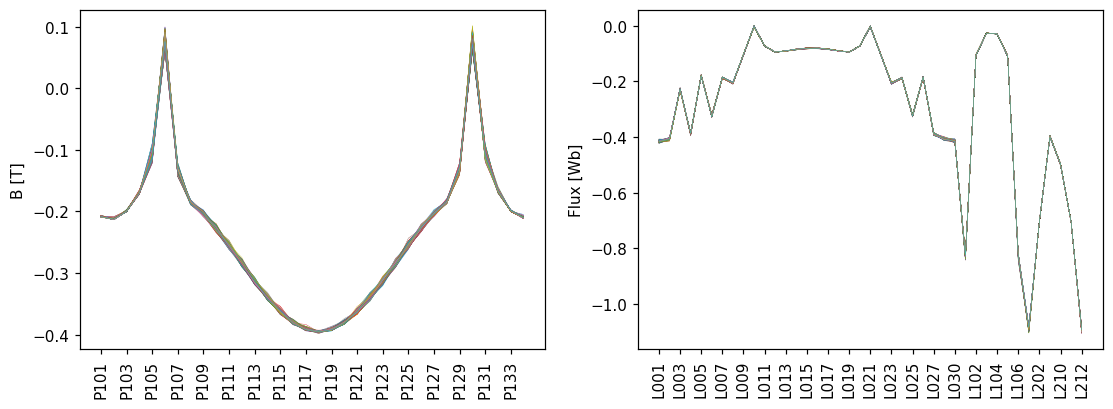

In [12]:
plot_magnetic_probes(gsfit_controller)

In [13]:
gsfit_controller_w_new_sensors = Gsfit(
    pulseNo=None,
    run_name="test_01",
    run_description="using FreeGS to generate measurements",
    settings_path="st40_all_magnetic_sensors_working",
    write_to_mds=False,
)
gsfit_controller_w_new_sensors.settings["GSFIT_code_settings.json"]["database_reader"]["method"] = "freegs"
gsfit_controller_w_new_sensors.settings["GSFIT_code_settings.json"]["timeslices"]["method"] = "user_defined"
gsfit_controller_w_new_sensors.settings["GSFIT_code_settings.json"]["numerics"]["gs_error"] = 2.0e-5

new_sensors = {
    "P135": {
        "r": 0.30001,
        "z": -0.700001,
        "angle": np.pi + np.pi / 8.0,
    }
}

# Add the new sensors
freegs_sensors_with_new = copy.deepcopy(freegs_eq.tokamak.sensors)
for sensor_name in new_sensors.keys():
    # Add the new sensor
    sensor_name_full = f"{sensor_name}_BOTTOM"
    freegs_sensor = freegs.machine.PoloidalFieldSensor(
        R=new_sensors[sensor_name]["r"],
        Z=-new_sensors[sensor_name]["z"],
        theta=new_sensors[sensor_name]["angle"],
        name=sensor_name_full,
    )
    freegs_sensors_with_new.append(freegs_sensor)
    new_sensor_settings = {
        "fit_settings": {
            "expected_value": 0.01,
            "weight": 10.0,
            "include": True,  # Include the new sensor in the fit
            "comment": "new sensor",
        }
    }
    gsfit_controller_w_new_sensors.settings["sensor_weights_bp_probe.json"][sensor_name_full] = new_sensor_settings

    # Add the corresponding sensor to the top
    sensor_name_full = f"{sensor_name}_TOP"
    freegs_sensor = freegs.machine.PoloidalFieldSensor(
        R=new_sensors[sensor_name]["r"],
        Z=-new_sensors[sensor_name]["z"],
        theta=new_sensors[sensor_name]["angle"] + 2.0 * np.pi,
        name=sensor_name_full,
    )
    freegs_sensors_with_new.append(freegs_sensor)
    gsfit_controller_w_new_sensors.settings["sensor_weights_bp_probe.json"][sensor_name_full] = new_sensor_settings

# Add the new sensors to the FreeGS object
freegs_eq_with_new_sensors = copy.deepcopy(freegs_eq)
freegs_eq_with_new_sensors.tokamak.sensors = freegs_sensors_with_new
freegs_eq_with_new_sensors.tokamak.takeMeasurements(eq=freegs_eq_with_new_sensors)

# Add random noise to the positions of the magnetic sensors
freegs_eqs_with_random_noise = []
freegs_eqs_with_random_noise.append(freegs_eq_with_new_sensors)  # The original equilibrium is first
for i_random_scan in range(1, n_random_scans):
    freegs_eq_with_random_noise = copy.deepcopy(freegs_eq_with_new_sensors)
    # Use the rng Generator for deterministic random noise
    for i_sensor, sensor in enumerate(freegs_eq_with_new_sensors.tokamak.sensors):
        # measurement = sensor.measurement
        r_sensor = sensor.R
        z_sensor = sensor.Z

        # Add random normal noise to the sensor positions
        freegs_eq_with_random_noise.tokamak.sensors[i_sensor].R = rng.normal(r_sensor, 2e-3)
        freegs_eq_with_random_noise.tokamak.sensors[i_sensor].Z = rng.normal(z_sensor, 2e-3)

        try:
            angle_no_noise = sensor.theta
            freegs_eq_with_random_noise.tokamak.sensors[i_sensor].theta = rng.normal(angle_no_noise, np.deg2rad(2.5))
        except:
            pass

    # Take measurements
    freegs_eq_with_random_noise.tokamak.takeMeasurements(eq=freegs_eq_with_random_noise)

    # Append the modified equilibrium to the list to be reconstructed
    freegs_eqs_with_random_noise.append(freegs_eq_with_random_noise)

time = np.linspace(0.0, 1.0, n_random_scans)

gsfit_controller_w_new_sensors.settings["GSFIT_code_settings.json"]["timeslices"]["user_defined"] = time.tolist()

# Solve with random noise
gsfit_controller_w_new_sensors.run(time=time, freegs_eqs=freegs_eqs_with_random_noise)

2025-07-15 22:00:07  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "GSFIT_code_settings.json"
2025-07-15 22:00:07  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "passive_dof_regularisation.json"
2025-07-15 22:00:07  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_bp_probe.json"
2025-07-15 22:00:07  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_dialoop.json"
2025-07-15 22:00:07  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_flux_loops.json"
2025-07-15 22:00:07  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_isoflux.json"
2025-07-15 22:00:07  |  GSFIT  |  diagnostic_and_simulation_base.py:159  |  INFO  |  Loading settings from: "sensor_weights_pressure.json"
2025-07-15 22:00:07  |  GSFI

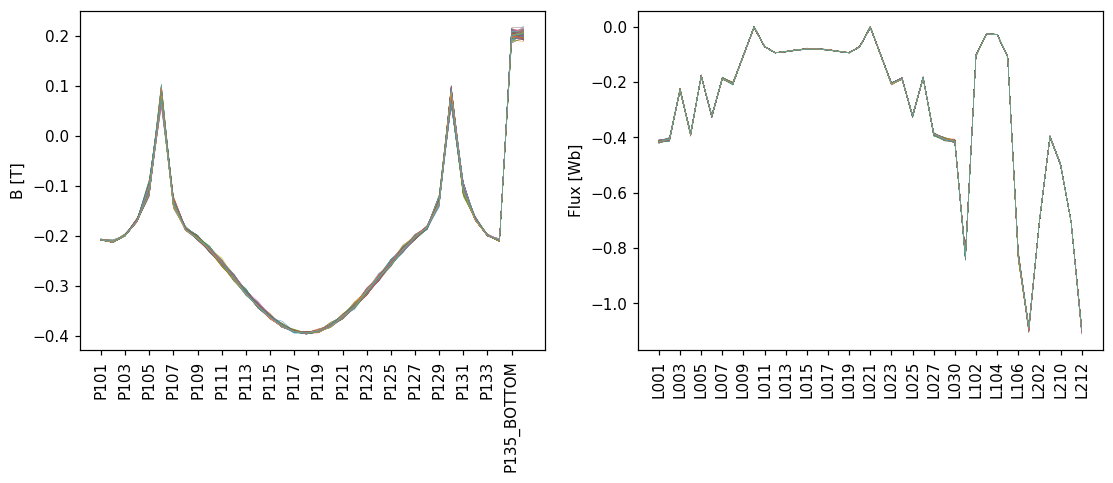

In [14]:
plot_magnetic_probes(gsfit_controller_w_new_sensors)

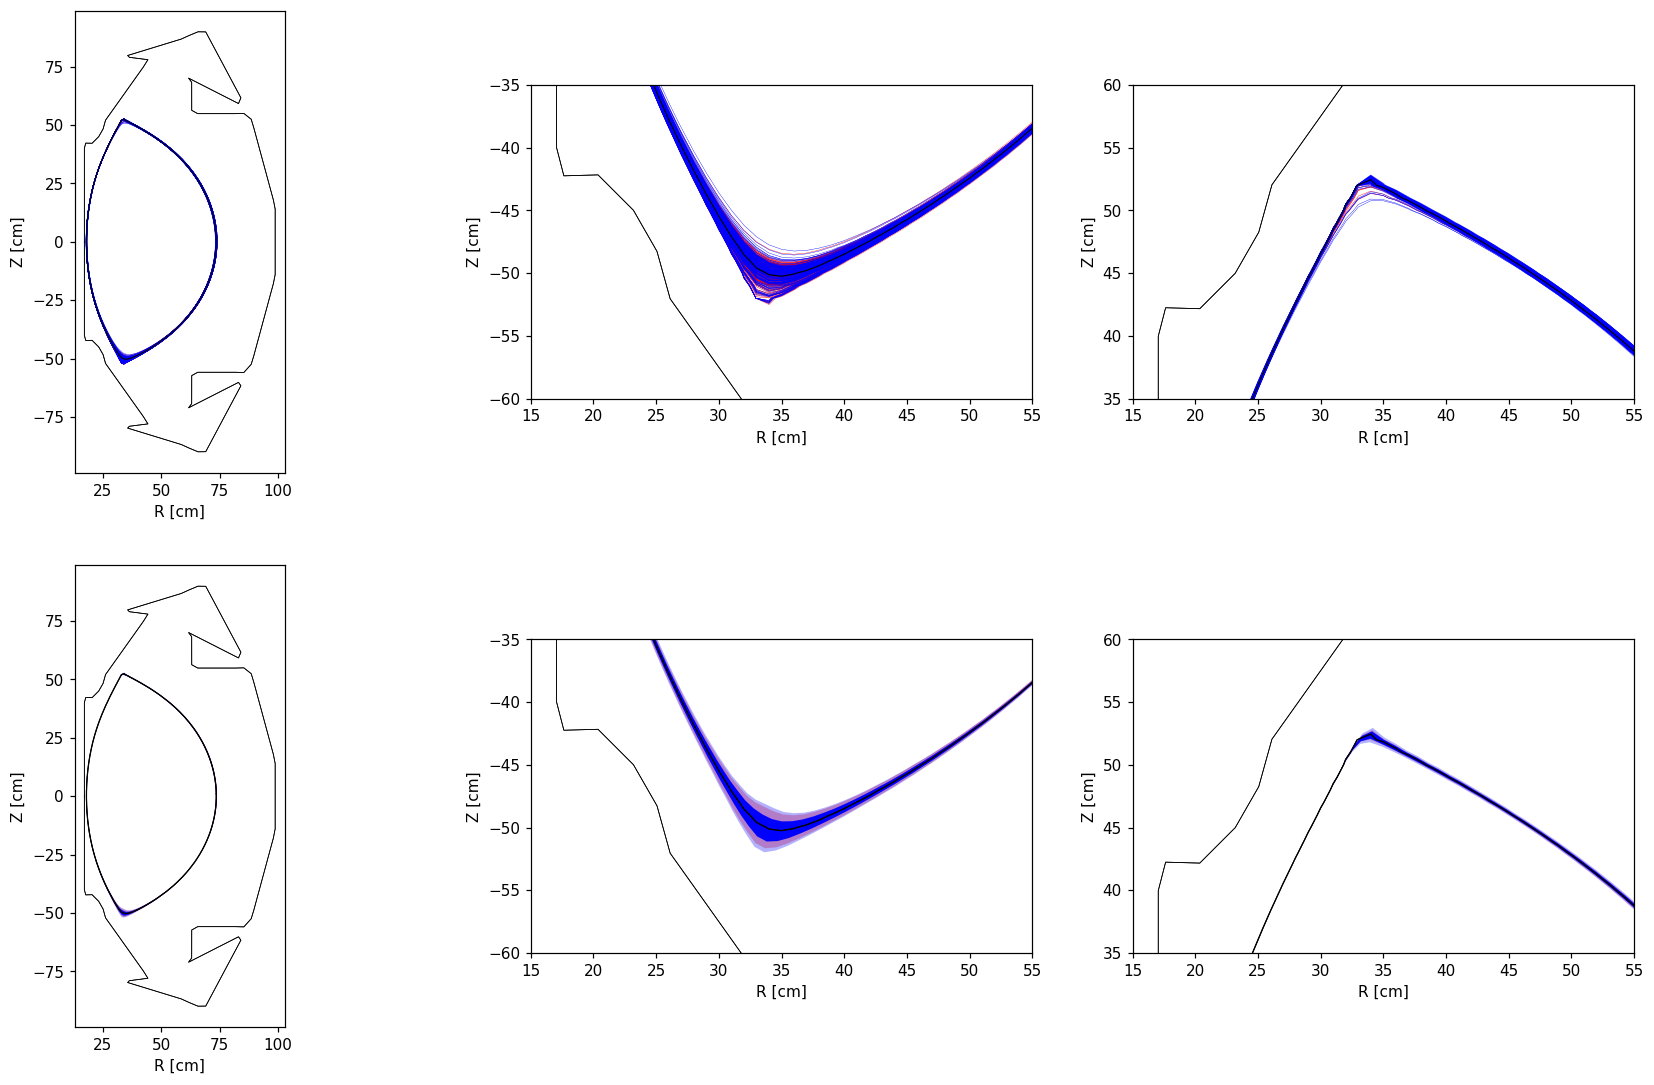

In [15]:
_fig, ax = plt.subplots(2, 3, figsize=(20, 12), dpi=110)
plot_equilibrium(gsfit_controller, ax=ax)
plot_equilibrium(gsfit_controller_w_new_sensors, plot_color="blue", ax=ax)